In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm
from statsmodels.stats.weightstats import _tconfint_generic
%matplotlib inline

In [105]:
df=pd.read_csv('winemag-data_first150k.csv')

In [106]:
df.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Расшифровка значений<br>
country - Страна происхождения вина <br>
designation - Виноградник на винодельне, откуда взят виноград из которого произведено вино<br>
points - Количество баллов которыми WineEnthusiast оценил вино по шкале от 1 до 100 (опублкованы отзывы только о винах, набравших >=80)<br>
price - Стоимость бутылки вина<br>
province - Область в котором произведено вино<br>
region_1 - Регион в котором выращен виноград (например, Napa)<br>
region_2 - Иногда указаны более конкретные регионы (например, Rutherford внутри the Napa Valley), иногда значение может быть пустым<br>
variety - Сорт винограда (например, Pinot Noir)<br>
winery - Винодельня<br>

In [119]:
df=df.dropna()
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   39241 non-null  int64  
 1   country      39241 non-null  object 
 2   description  39241 non-null  object 
 3   designation  39241 non-null  object 
 4   points       39241 non-null  int64  
 5   price        39241 non-null  float64
 6   province     39241 non-null  object 
 7   region_1     39241 non-null  object 
 8   region_2     39241 non-null  object 
 9   variety      39241 non-null  object 
 10  winery       39241 non-null  object 
 11  expensive    39241 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 3.9+ MB


### Рассмотрим распределение цен на вино

<Axes: >

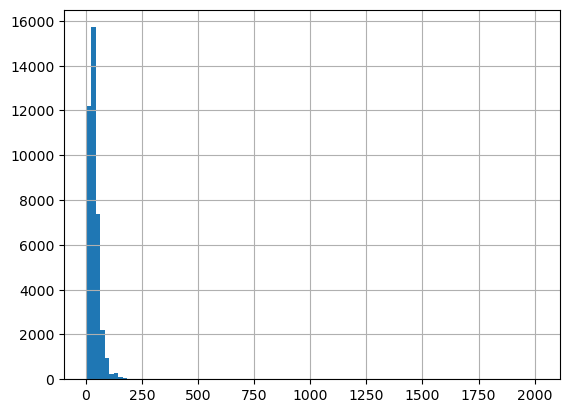

In [120]:
df['price'].hist(bins=100)

#### Из распределения видно наличие выбросов - небольшое количество вин с очень высокой стоимостью.
#### Отфильтруем выбросы и построим новую гистограмму распределения.

<Axes: >

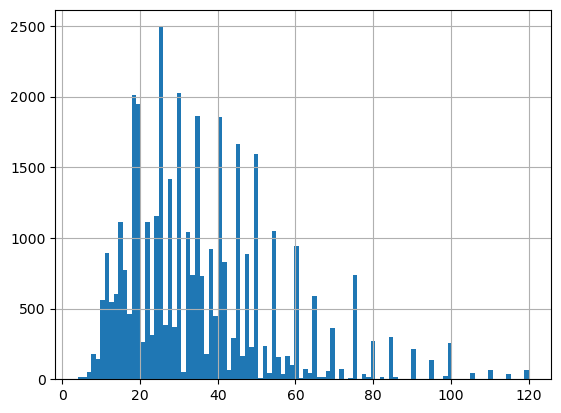

In [121]:
df[df['price'] < df['price'].quantile(0.99)]['price'].hist(bins=100)

#### Разделим выборку пополам и определим две группы вин: дешевые и дорогие. Определим медианное значение стоимости вина и укажем его в качестве порогового значения при разделении на группы:

In [122]:
df['price'].median()

32.0

In [130]:
threshold = df['price'].median()
df['expensive'] = df['price'].apply(lambda x: 1 if x > threshold else 0)

In [131]:
df[df['expensive'] == 1].shape, df[df['expensive'] == 0].shape

((19278, 12), (19963, 12))

#### В выборке представлены оценки для 19 278 дорогих и 19 963 недорогих вин

### Определим долю дорогих вин производимых в каждой из представленных областей

In [125]:
for province in df['province'].unique():
    df_prop = df[df['province'] == province]
    prop = sum(df_prop['expensive']) / len(df_prop)
    print('proportion of expensive wines in {0} is {1}'.format(province,prop))

proportion of expensive wines in California is 0.5257905242147284
proportion of expensive wines in Oregon is 0.5805070793546263
proportion of expensive wines in Washington is 0.3753675269519765
proportion of expensive wines in New York is 0.13245901639344262


### Определим доверительные интервалы для найденных пропорций

In [126]:
for province in df['province'].unique():
    df_prop = df[df['province'] == province]
    prop = sum(df_prop['expensive']) / len(df_prop)
    # Применим функцию proportion_confint со следующими параметрами:
    # count = sum(df_prop['expensive']) - количество наблюдений,
    # nobs = len(df_prop) - количество объектов учавствующих в выборке,
    # alpha = 0.05 - параметр определяющий доверительную вероятность 95%
    prop_int = proportion_confint(sum(df_prop['expensive']),len(df_prop),alpha=0.05,method='normal')
    print('confidence interval for proportion of expensive wines in {0} is {1}'.format(province,prop_int))

confidence interval for proportion of expensive wines in California is (0.5199991278163051, 0.5315819206131517)
confidence interval for proportion of expensive wines in Oregon is (0.5629564872321101, 0.5980576714771425)
confidence interval for proportion of expensive wines in Washington is (0.36323805046059787, 0.38749700344335514)
confidence interval for proportion of expensive wines in New York is (0.11544531006168147, 0.1494727227252038)


#### Так как доверительный интервал для доли дорогих вин находится правее всех остальных интервалов, делаем вывод о том, что с 95% вероятностью можно утверждать что наибольшая доля дорогих вин производится в Орегоне

### Определим среднюю оценку среди дорогих и дешевых вин

In [127]:
expensive_mean_points = round(df[df['expensive'] ==1]['points'].mean(),2)
cheap_mean_points = round(df[df['expensive'] ==0]['points'].mean(),2)

expensive_mean_points, cheap_mean_points

(89.88, 86.89)

#### Для определения доверительного интервала воспользуемся функцией _tconfint_generic

In [128]:
expensive_mean_std = df[df['expensive'] == 1]['points'].std()/np.sqrt(len(df[df['expensive'] == 1]['points']))

cheap_mean_std = df[df['expensive'] == 0]['points'].std()/np.sqrt(len(df[df['expensive'] == 0]['points']))

In [129]:
expensive_interval = _tconfint_generic(expensive_mean_points, expensive_mean_std, len(df[df['expensive'] == 1]['points']) - 1,\
                                  0.01,alternative='two-sided')
cheap_interval = _tconfint_generic(cheap_mean_points, cheap_mean_std, len(df[df['expensive'] == 0]['points']) - 1,\
                                   0.01,alternative='two-sided')
expensive_interval, cheap_interval

((89.81903980095062, 89.94096019904937), (86.837085152533, 86.942914847467))

#### Доверительный интервал для средней оценки дорогих вин находится правее. Таким образом можно утверждать, что средняя оценка среди дорогих вин выше, чем среди дешевых.

### Определим наиболее популярные сорта вин и проанализируем их оценки

In [134]:
# Создадим список 5 популярных сортов
variety=list(df['variety'].value_counts().head(5).index)
variety

['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Zinfandel']

In [136]:
# Зададим список в качестве фильтра для нашего ДФ
wine_top_variety = df[df['variety'].isin(variety)]
wine_top_variety

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,expensive
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,1
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,1
11,11,US,"From 18-year-old vines, this supple well-balan...",Estate Vineyard Wadensvil Block,95,48.0,Oregon,Ribbon Ridge,Willamette Valley,Pinot Noir,Patricia Green Cellars,1
...,...,...,...,...,...,...,...,...,...,...,...,...
150856,150856,US,White Merlot? Why not? It's actually a deep ro...,Forest Fire,84,8.0,California,California,California Other,Chardonnay,Forest Glen,0
150861,150861,US,From a dependable producer and a fine vintage ...,Reserve,84,16.0,California,Sonoma County,Sonoma,Chardonnay,Clos du Bois,0
150873,150873,US,With a color akin to the soft pink of ripe pea...,White,83,7.0,California,Amador County,Sierra Foothills,Zinfandel,Montevina,0
150883,150883,US,"A coppery colored, off-dry-to-frankly-sweet wi...",Reserve White,83,7.0,California,California,California Other,Zinfandel,Glen Ellen,0


In [137]:
#Cгруппируем таблицу по сортам и оценкам, а затем транспонируем
wine_counts = wine_top_variety.groupby(['variety','points'])['points'].count().unstack().T
wine_counts

variety,Cabernet Sauvignon,Chardonnay,Pinot Noir,Red Blend,Zinfandel
points,,,,,
80,19.0,7.0,5.0,43.0,43.0
81,34.0,22.0,17.0,40.0,52.0
82,137.0,114.0,110.0,117.0,195.0
83,125.0,161.0,138.0,153.0,205.0
84,219.0,307.0,241.0,261.0,268.0
85,273.0,339.0,333.0,225.0,228.0
86,335.0,425.0,491.0,251.0,277.0
87,521.0,639.0,840.0,363.0,384.0
88,396.0,486.0,724.0,377.0,261.0


<Axes: xlabel='points'>

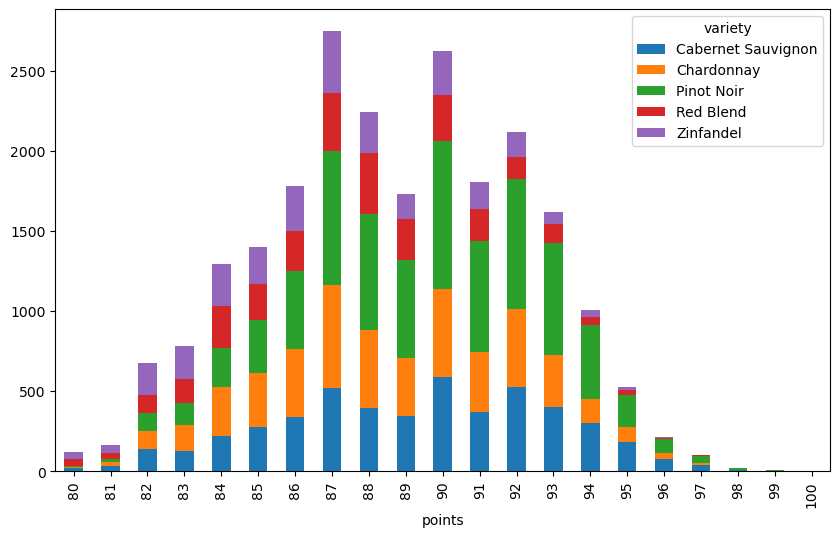

In [138]:
wine_counts.plot.bar(stacked=True, figsize=(10, 6))

### Создадим функцию для поиска лучших вин выпускаемых винодельней

In [184]:
def winery_top_production(winery):
    df_winery = df.loc[df['winery'] == winery]
    max_points_row = df_winery.loc[df_winery['points'].idxmax()]
    return pd.DataFrame([max_points_row], columns=df.columns)

In [185]:
winery_top_production('Sloan')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,expensive
114272,114272,US,Impossibly aromatic. Hard to imagine greater c...,Red Wine,100,245.0,California,Rutherford,Napa,Cabernet Blend,Sloan,1
